In [79]:
import numpy as np
import gymnasium as gym
import torch
import collections
import random
import copy
import torch.nn.functional as F
from typing import Tuple
import matplotlib.pyplot as plt
import pandas as pd

In [80]:
class DDPG_Agent():
    
    def __init__(self,
                 action_scale:torch.tensor,
                 action_upper_bound:np.ndarray,
                 action_lower_bound:np.ndarray,
                 replay_buffer:collections.deque,
                 replay_start_size:int,
                 batch_size:int,
                 actor_update_frequent:int, # The frequency of updating the actor network
                 target_update_tau:float, # The parameter for soft update
                 actor_network:torch.nn, 
                 critic_network:torch.nn,
                 actor_optimizer:torch.optim,
                 critic_optimizer:torch.optim,
                 gamma:float = 0.9,
                 sigma_noise:float = 0.2,
                 device:torch.device = torch.device("cpu")
                 ) -> None:
        
        self.device = device
        
        self.exp_counter = 0
        
        self.replay_buffer = replay_buffer
        self.replay_start_size = replay_start_size
        self.batch_size = batch_size
        
        self.actor_update_frequent = actor_update_frequent
        self.target_update_tau = target_update_tau
        
        self.main_critic_network = critic_network.to(self.device)
        self.target_critic_network = copy.deepcopy(critic_network).to(self.device)
        self.main_actor_network = actor_network.to(self.device)
        self.target_actor_network = copy.deepcopy(actor_network).to(self.device)
        
        self.critic_optimizer = critic_optimizer
        self.actor_optimizer = actor_optimizer
        
        self.gamma = gamma
        self.sigma_noise = sigma_noise
        self.action_scale = action_scale
        self.action_upper_bound = action_upper_bound
        self.action_lower_bound = action_lower_bound
        
        
    def get_behavior_action(self,obs:np.ndarray) -> np.ndarray:        
        obs = torch.tensor(obs,dtype=torch.float32).to(self.device)
        action = self.main_actor_network(obs)
        action += torch.normal(0, self.action_scale * self.sigma_noise)
        action = action.cpu().detach().numpy().clip(self.action_lower_bound,self.action_upper_bound)
        
        return action
    
    def soft_update_network(self,main_network:torch.nn,target_network:torch.nn) -> None:
        """Soft update the parameters of the target network"""
        for target_param, main_param in zip(target_network.parameters(), main_network.parameters()):
            target_param.data.copy_(self.target_update_tau * main_param.data + (1.0 - self.target_update_tau) * target_param.data)
            
    def batch_Q_approximation(self,
                              obs:torch.tensor,
                              action:torch.tensor,
                              reward:torch.tensor,
                              next_obs:torch.tensor,
                              done:torch.tensor) -> None:
        """To update the main critic network"""
        current_Q = self.main_critic_network(obs,action).squeeze(1)
        TD_target = reward + (1-done) * self.gamma * self.target_critic_network(next_obs,self.target_actor_network(next_obs)).squeeze(1)
        critic_loss = torch.mean(F.mse_loss(current_Q,TD_target.detach())) # detach the TD_target for frozen the parameters of the target network
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        
    def batch_actor_update(self,obs:torch.tensor) -> None:
        
        """To update the main actor network. 
            However, before that, we need to freeze the parameters of the main critic network"""
        for p in self.main_critic_network.parameters():
            p.requires_grad = False
        
        actor_loss = torch.mean(-self.main_critic_network(obs,self.main_actor_network(obs)))       
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        """After updating the main actor network, 
            we need to unfreeze the parameters of the main critic network"""
        for p in self.main_critic_network.parameters():
            p.requires_grad = True    
            
            
    def Q_approximation(self,
                    obs:np.ndarray,
                    action:int,
                    reward:float,
                    next_obs:np.ndarray,
                    done:bool) -> None:
        
        """Here, we continue use the framework of DQN, since DDPG is an extension of DQN.
            The max Q value is approximated by the target network."""
        
        self.exp_counter += 1
        self.replay_buffer.append((obs,action,reward,next_obs,done))

        if len(self.replay_buffer) > self.replay_start_size:
            obs,action,reward,next_obs,done = self.replay_buffer.sample(self.batch_size)
            self.batch_Q_approximation(obs,action,reward,next_obs,done) # train critic 
            if self.exp_counter%self.actor_update_frequent == 0: # update actor network every actor_update_frequent steps
                self.batch_actor_update(obs) # train actor
                self.soft_update_network(self.main_critic_network,self.target_critic_network) # soft update target networks
                self.soft_update_network(self.main_actor_network,self.target_actor_network)             

In [81]:
class Actor_Network(torch.nn.Module):
    def __init__(self,obs_dim:int,action_dim:int,action_scale:torch.tensor,action_bias:torch.tensor) -> None:
        super(Actor_Network,self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,64)
        self.fc2 = torch.nn.Linear(64,action_dim)
        self.action_scale = action_scale
        self.action_bias = action_bias
            
    def forward(self,x:torch.tensor) -> torch.tensor:
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        
        return x * self.action_scale + self.action_bias
    

class Critic_Network(torch.nn.Module):
    def __init__(self,obs_dim:int,action_dim:int) -> None:
        super(Critic_Network,self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim + action_dim,64)
        self.fc2 = torch.nn.Linear(64,1)
            
    def forward(self,o:torch.tensor,a:torch.tensor) -> torch.tensor:
        x = torch.cat([o,a],dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
                
        return x 

In [82]:
class ReplayBuffer():
    def __init__(self,capacity:int,device:torch.device = torch.device("cpu")) -> None:
        self.device = device
        self.buffer = collections.deque(maxlen=capacity)
        
    def append(self,exp_data:tuple) -> None:
        self.buffer.append(exp_data)
        
    def sample(self,batch_size:int) -> Tuple[torch.tensor,torch.tensor,torch.tensor,torch.tensor,torch.tensor]:
        mini_batch = random.sample(self.buffer,batch_size)
        obs_batch, action_batch, reward_batch, next_obs_batch, done_batch = zip(*mini_batch)
        
        obs_batch = torch.tensor(np.array(obs_batch),dtype=torch.float32,device=self.device)
        
        action_batch = torch.tensor(np.array(action_batch),dtype=torch.float32,device=self.device) 

        
        reward_batch = torch.tensor(reward_batch,dtype=torch.float32,device=self.device)
        next_obs_batch = torch.tensor(np.array(next_obs_batch),dtype=torch.float32,device=self.device)
        done_batch = torch.tensor(done_batch,dtype=torch.float32,device=self.device)
          
        return obs_batch, action_batch, reward_batch, next_obs_batch, done_batch
    
    def __len__(self) -> int:
        return len(self.buffer)

In [83]:
class TrainManager():
    
    def __init__(self,
                 env:gym.Env,
                 episode_num:int = 1000,
                 actor_lr:float = 1e-3,
                 critic_lr:float = 1e-3,
                 gamma:float = 0.95,
                 sigma_noise:float = 0.2,
                 buffer_capacity:int = 2000,
                 replay_start_size:int = 200,
                 actor_update_frequent:int = 2,
                 target_update_tau:float = 1e-3,
                 batch_size:int = 32,
                 seed:int = 0,
                 my_device:str = "cpu"
                 ) -> None:
        
        self.seed = seed
        random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(self.seed)
        torch.backends.cudnn.deterministic = True
        
        self.device = torch.device(my_device)
        
        self.env = env
        self.episode_num = episode_num
        obs_dim = gym.spaces.utils.flatdim(env.observation_space)
        action_dim = gym.spaces.utils.flatdim(env.action_space)
        action_upper_bound = env.action_space.high
        action_lower_bound = env.action_space.low
        action_bias = (action_upper_bound + action_lower_bound) / 2.0
        action_bias = torch.tensor(action_bias,dtype=torch.float32).to(self.device)
        action_scale = (action_upper_bound - action_lower_bound) / 2.0
        action_scale = torch.tensor(action_scale,dtype=torch.float32).to(self.device)
        
        
        self.buffer = ReplayBuffer(capacity=buffer_capacity,device=self.device)
        
        actor_network = Actor_Network(obs_dim,action_dim,
                                      action_scale,action_bias).to(self.device)
        actor_optimizer = torch.optim.Adam(actor_network.parameters(),lr=actor_lr)
        critic_network = Critic_Network(obs_dim,action_dim).to(self.device)
        critic_optimizer = torch.optim.Adam(critic_network.parameters(),lr=critic_lr)
        self.agent = DDPG_Agent(action_scale = action_scale,
                                action_upper_bound = action_upper_bound,
                                action_lower_bound = action_lower_bound,
                                replay_buffer = self.buffer,
                                replay_start_size = replay_start_size,
                                batch_size = batch_size,
                                actor_update_frequent = actor_update_frequent, 
                                target_update_tau = target_update_tau,
                                actor_network = actor_network,
                                critic_network = critic_network,
                                actor_optimizer = actor_optimizer,
                                critic_optimizer = critic_optimizer,
                                gamma = gamma,
                                sigma_noise = sigma_noise,
                                device = self.device)
        
        self.episode_total_rewards = np.zeros(episode_num)
        self.index_episode = 0 
        
    def train_episode(self) -> float:
        total_reward = 0 
        obs,_ = self.env.reset(seed=self.seed) 
        while True:
            action = self.agent.get_behavior_action(obs) 
            next_obs, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            total_reward += reward 
            self.agent.Q_approximation(obs,action,reward,next_obs,done)
            obs = next_obs                 
            if done:
                self.episode_total_rewards[self.index_episode] = total_reward
                self.index_episode += 1
                break
            
        return total_reward    
        
    def train(self) -> None:        
        for e in range(self.episode_num):
            episode_reward = self.train_episode()
            if e%50 == 0:
                print('Episode %s: Total Reward = %.2f'%(e,episode_reward)) 
                        
    def plotting(self,smoothing_window:int = 50) -> None:    
        """ Plot the episode reward over time. """
        fig = plt.figure(figsize=(10,5))
        plt.plot(self.episode_total_rewards,label="Episode Reward")
        # Use rolling mean to smooth the curve
        rewards_smoothed = pd.Series(self.episode_total_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
        plt.plot(rewards_smoothed,label="Episode Reward (Smoothed)")
        plt.xlabel('Episode')
        plt.ylabel('Episode Reward')
        plt.title("Episode Reward over Time")
        plt.legend()
        plt.show()                            

Episode 0: Total Reward = -1161.31
Episode 50: Total Reward = -490.21
Episode 100: Total Reward = -132.30
Episode 150: Total Reward = -130.44
Episode 200: Total Reward = -132.88
Episode 250: Total Reward = -128.14
Episode 300: Total Reward = -473.91
Episode 350: Total Reward = -128.69
Episode 400: Total Reward = -130.46
Episode 450: Total Reward = -267.01


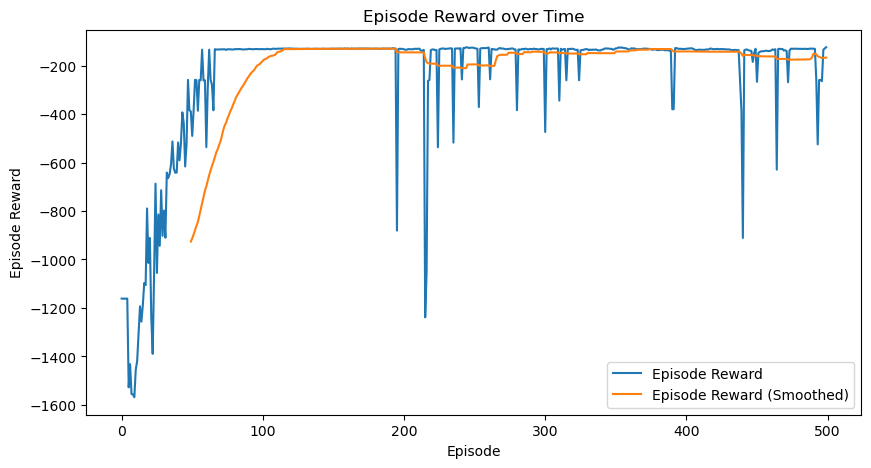

In [84]:
if __name__ == "__main__":
    env = gym.make('Pendulum-v1')
    Manger = TrainManager(env = env,
                        episode_num = 500,
                        actor_lr = 1e-3,
                        critic_lr = 1e-2,
                        gamma = 0.95,
                        sigma_noise = 0.01,
                        buffer_capacity = 10000,
                        replay_start_size = 1000,
                        actor_update_frequent = 1,
                        target_update_tau = 5e-3,
                        batch_size = 64,
                        seed = 0,
                        my_device = "cpu"
                        )
    Manger.train()
    Manger.plotting()